In [2]:
# JSS
## TODO 
#using pca to reduce the dimensionality of the global descriptors
#using MobileVnet instead of netVLAD
#using hfnet instead of netVlAD and MobileVnet 
# this will also help reduce the complexity 
#understand what superglue is outputting
# getting two models from SFM 
# Setting up the scale of the model

import numpy as np
import argparse
import yaml
import logging
from pathlib import Path
from tqdm import tqdm
from pprint import pformat
import h5py
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# from notebooks.utils import plot_images, plot_matches, add_frame

In [3]:
from hfnet.models import get_model  

In [4]:
# send the path to the image directory and get the path to all the images in it
def image_directory_parser(path, viewer=True, number= 4):    
    globs=['*.jpg', '*.png', '*.jpeg', '*.JPG', '*.PNG']
    ## can also use sufix instead of with method
    image_path = []
    for g in globs:
        image_path += list(path.glob("**/"+g))
    if viewer:
        nrows = number
        ncols = number
        fig = plt.gcf()
        fig.set_size_inches(ncols*4, ncols*4)
        for i in range(2*number):
            sp = plt.subplot(nrows, ncols, i + 1)
            sp.axis('Off') # Don't show axes (or gridlines)
            img = mpimg.imread((image_path[i]))
            plt.imshow(img)
        plt.show()
    return image_path

# image dictionary creator gives image, its name and index as dictionary
def dictionary_of_images(image_path):
    image_dict ={}
    for i,j in tqdm(enumerate(image_path)):
        image_array = cv2.imread(str(j))
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
        image_dict[i] = {"image":image_array, "name": image_path[i].name, "number": i}
    return image_dict
# this finds the global matrix and 
def global_dict_matrix_and_H5_map(config, image_dict):
    predictions_dict = {}
    global_feature_path = (config["output"])/"global_features_y1112.h5"
    global_feature_file = h5py.File(str(global_feature_path), 'w')
    checkpoint_path = Path(config["checkpoint_path"])
    keys = ['global_descriptor']    
    with get_model(config['model']['name'])(
            data_shape={'image': [None, None, None, 3]},
            **config['model']) as net:
        if checkpoint_path is not None:
            net.load(str(checkpoint_path))
        for i in tqdm(range(len(image_dict))):
            data = image_dict[i] ## selecting using index
            predictions = net.predict(data, keys=keys)
            predictions_dict[i] = {"global_descriptor":predictions['global_descriptor'], "name" : data['name']}   
            if i == 0:
                global_matrix = np.array(predictions['global_descriptor'])
            else:
                global_matrix = np.vstack((global_matrix,predictions['global_descriptor']))
            grp = global_feature_file.create_group(data['name'])
            grp.create_dataset('global_descriptor', data=predictions['global_descriptor'])
        global_feature_file.close()
    return predictions_dict, global_matrix

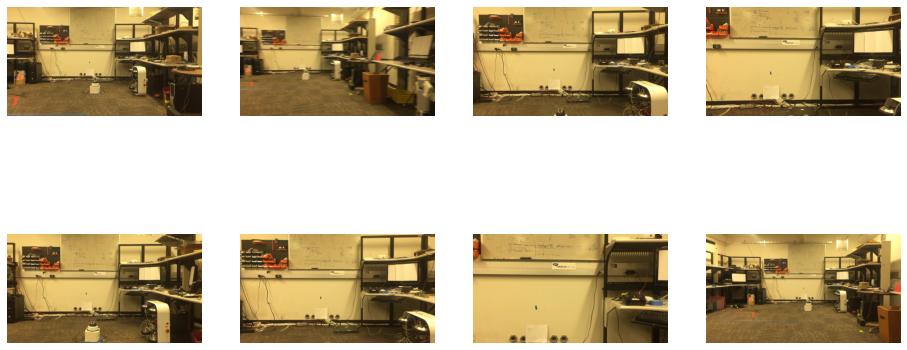

102it [00:00, 109.13it/s]


In [5]:
path_to_images_for_map = Path('/home/Hierarchical-Localization/datasets/UsefulImagesT3')
image_path = image_directory_parser(path_to_images_for_map, viewer=True, number = 4)
image_dict = dictionary_of_images(image_path)

In [6]:
output_path = Path("/home/Hierarchical-Localization/outputs/sfm_T3")
checkpoint_path = Path("/home/Hierarchical-Localization/weights/vd16_pitts30k_conv5_3_vlad_preL2_intra_white/vd16_pitts30k_conv5_3_vlad_preL2_intra_white")

In [7]:
config_global = {'output':output_path, 'checkpoint_path':checkpoint_path, 'data': {'name': 'aachen', 'load_db': False, 'load_queries': True, 'resize_max': 960}, 'model': {'name': 'netvlad_original', 'local_descriptor_layer': 'conv3_3', 'image_channels': 1}, 'weights': 'vd16_pitts30k_conv5_3_vlad_preL2_intra_white/vd16_pitts30k_conv5_3_vlad_preL2_intra_white'}         
global_dict_map, global_matrix = global_dict_matrix_and_H5_map(config_global, image_dict)

W0219 11:19:37.393714 140579072468800 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:104: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0219 11:19:37.410650 140579072468800 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:124: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0219 11:19:37.411924 140579072468800 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:124: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0219 11:19:37.413047 140579072468800 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:275: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0219 11:19:37.416372 140579072468800 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/h

In [8]:
def compute_distance(desc1, desc2):
    # For normalized descriptors, computing the distance is a simple matrix multiplication.
    return 2 * (1 - desc1 @ desc2.T)
## needs both global matrix and dict as we need to give names too
## I am idiot if I keep wiritng codes like this one lol ;)
# Need to change it hehehe
# Writing the .txt file.
def text_file_for_global_matches(global_feature_dict, global_feature_matrix, path, number): 
    predictions_dict_matches = {}
    for i in tqdm(range(len(global_feature_dict))):
        current_descriptor = global_feature_matrix[i, :]
        neighbours = compute_distance(current_descriptor, global_feature_matrix)
        predictions_dict_matches[i] = ((np.argsort(neighbours))[:number])[1 :]
    #first writing the file
    output_file_txt = path/"global_feature.txt"
    with open(output_file_txt, 'w') as f:
        for i in tqdm(range(len(predictions_dict_matches))):
            current_image_name = global_feature_dict[i]["name"]
            current_image_matches = predictions_dict_matches[i]
            string_list = []
            for j in range(len(current_image_matches)):
                    if i == 0 and j ==0:
                        making_a_string = current_image_name + " " + global_feature_dict[current_image_matches[j]]["name"]
                    
                    else: 
                        making_a_string = "\n" + current_image_name + " " + global_feature_dict[current_image_matches[j]]["name"]
                    f.write(making_a_string)  
    ## checking common lines and rewriting
    image_list_for_finding_common_separated = []
    with open(output_file_txt, 'r') as f:
        image_list_for_finding_common = [l.strip() for l in f]
    for i in range(len(image_list_for_finding_common)):
        current_index_value = image_list_for_finding_common[i]
        current_index_value = list(current_index_value.split(" "))
        image_list_for_finding_common_separated.append(sorted(current_index_value))
    ilf = sorted(image_list_for_finding_common_separated)
    final_list = []
    for i in range(len(ilf)):
        if ilf[i] in final_list:
            pass
        else:
            final_list.append(ilf[i])
    with open(output_file_txt, 'w') as f:
        for i in range(len(final_list)):
            if i == 0:
                making_a_string = final_list[i][0]+ " " + final_list[i][1]
            else:
                making_a_string = "\n" + final_list[i][0]+ " " + final_list[i][1]
            f.write(making_a_string)

In [9]:
text_file_for_global_matches(global_dict_map, global_matrix,output_path,5)

100%|██████████| 102/102 [00:00<00:00, 85872.94it/s]


In [10]:
### Bringing in HLOC
%load_ext autoreload
%autoreload 2

from pathlib import Path

from hloc import extract_features, match_features, reconstruction, visualization

In [11]:
dataset = Path('datasets')
images = dataset / 'UsefulImagesT3'

outputs = Path('outputs/sfm_T3/')
sfm_pairs = Path('outputs/global_features_T3.txt')  # exhaustive matching
sfm_dir = outputs / 'sfm_superpoint+superglue'

feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

features = feature_conf['output']
feature_file = f"{features}.h5"
match_file = f"{features}_{matcher_conf['output']}_{sfm_pairs.stem}.h5"

In [14]:
# print(match_file)

feature_conf['output'] = new

NameError: name 'new' is not defined

In [15]:
extract_features.main(feature_conf, images, outputs)

I0219 11:22:12.711382 140579072468800 extract_features.py:123] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024_T3',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
I0219 11:22:12.766589 140579072468800 extract_features.py:81] Found 102 images in root datasets/UsefulImagesT3.
  0%|          | 0/102 [00:00<?, ?it/s]

Loaded SuperPoint model


  0%|          | 0/102 [00:00<?, ?it/s]


ValueError: Unable to create group (name already exists)

In [16]:
match_features.main(matcher_conf, sfm_pairs, features, outputs)

I0219 11:22:20.142732 140579072468800 match_features.py:42] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue_T3'}


AssertionError: outputs/global_features_T3.txt

In [ ]:
reconstruction.main(
    sfm_dir,
    images,
    sfm_pairs,
    outputs / feature_file,
    outputs / match_file)

In [ ]:
visualization.visualize_sfm_2d(sfm_dir / 'model', images, color_by='visibility', n=5)

In [ ]:
visualization.visualize_sfm_2d(sfm_dir / 'model', images, color_by='track_length', n=5)

In [ ]:
## test
#print(image_dic[0])
"""
## Finding the superpoint descriptors and keypoints

dataset_query = Path("datasets/Images_query_folder") ## will need to change this in future
query_stuff = feature_extractor_single.main(feature_conf, dataset_query)   # here output was the name of the folder
print(query_stuff)
"""

In [ ]:
from hloc import feature_extractor_single

In [ ]:
from hloc import feature_extractor_new
image_array_for_feature_detector = cv2.imread(str(dataset_query/"queryself"/"iPhoSilWithWv3_1598592406_309-03870.png"))
gray = cv2.cvtColor(image_array_for_feature_detector, cv2.COLOR_BGR2GRAY)

query_stuff = feature_extractor_new.main(feature_conf, gray)

In [ ]:
## finding the global descriptor
## creating a dictionary for images 
image_dic = {} ## creatinf dictionary because current method only accepts dictionary

image_array = cv2.imread(str(dataset_query/"queryself"/"iPhoSilWithWv3_1598592406_309-03870.png"))
image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)

image_dic_query_single = {"image":image_array} ## created the dictionary

if True:
    with get_model(config['model']['name'])(
            data_shape={'image': [None, None, None, 3]},
            **config['model']) as net:
        if checkpoint_path is not None:
            net.load(str(checkpoint_path)) ### loaded the model 

        predictions_query = net.predict(image_dic_query_single, keys=keys)


In [ ]:
## finding the index of global matches in the map space 
###creating a dictionary for matches 
current_descriptor_query = predictions_query['global_descriptor']
neighbours = compute_distance(current_descriptor_query, global_descriptor_matrix)
list_of_image_from_global_id = np.argsort(neighbours)[:10] ## stupid name change it 
### Lets match the features between the query image and the ones retrived from global index
list_of_image_from_global_name = [predictions_dict[i]["name"] for i in list_of_image_from_global_id]
# print(match_list_name)
# print(g)
# print(list_of_image_from_global_id)   ## this id is different from database ids
print(list_of_image_from_global_name)

In [ ]:
from hloc import match_feature_single
print(features)
matches_dict_single = match_feature_single.main(matcher_conf, query_stuff, list_of_image_from_global_name, features, outputs)
#print(matches_dict_single)
# print(matcher_conf)

In [ ]:
## Localization will need to send in the SFM model 
## will need to send the intrinsics too --- This is going to be a problem in future 

## What I have is :-
# match_dict_single == matches with the query image 
# query_stuff == query image keypoints name etc
# list_of_image_from_global == prior retrival using global features
# send query name 
# send query params 

query_stuff["params"] = ("SIMPLE_RADIAL", 640, 480, (658.503, 320, 180, 0.0565491))



In [ ]:
# print(query_stuff)
# print(list_of_image_from_global_name)
# print(matches_dict_single)
glob_model_dir = Path("geo-registered-model")

In [ ]:
from hloc import localize_sfm_single
pose = localize_sfm_single.main(glob_model_dir, query_stuff, list_of_image_from_global_name, outputs / f"{feature_conf['output']}.h5", matches_dict_single)  

In [1]:
def qvec2rotmat(qvec):
    return np.array([
        [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
         2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
         2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
        [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
         1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
         2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
        [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
         2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
         1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]])
def colmap_to_global(_tvec, _qvec):
    return -np.matmul(qvec2rotmat(_qvec).transpose(), _tvec)

In [ ]:
from hloc import feature_extractor_new
from hloc import match_feature_single
from hloc import localize_sfm_single
from hloc import extract_features, match_features, reconstruction, visualization
import IPython.display
import matplotlib.pyplot as plt
import jsonparser
def printer(image_path, image_name):
    outputs = Path('outputs/sfm_T3/')
    feature_conf = extract_features.confs['superpoint_aachen']
    image_array_for_feature_detector = cv2.imread(str(image_path))
    gray = cv2.cvtColor(image_array_for_feature_detector, cv2.COLOR_BGR2GRAY)
    query_stuff = feature_extractor_new.main(feature_conf, gray)
    image_dic = {} ## creatinf dictionary because current method only accepts dictionary
    image_array = cv2.imread(str(image_path))
    image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
    image_dic_query_single = {"image":image_array} ## created the dictionary
    if True:
        with get_model(config['model']['name'])(
                data_shape={'image': [None, None, None, 3]},
                **config['model']) as net:
            if checkpoint_path is not None:
                net.load(str(checkpoint_path)) ### loaded the model 
            predictions_query = net.predict(image_dic_query_single, keys=keys)
    
    _, ax = plt.subplots(1, figsize=(16,16))
    ax.imshow(image_array)
    ## finding the index of global matches in the map space 
    ###creating a dictionary for matches 
    current_descriptor_query = predictions_query['global_descriptor']
    neighbours = compute_distance(current_descriptor_query, global_descriptor_matrix)
    list_of_image_from_global_id = np.argsort(neighbours)[:10] ## stupid name change it 
    ### Lets match the features between the query image and the ones retrived from global index
    list_of_image_from_global_name = [predictions_dict[i]["name"] for i in list_of_image_from_global_id]
    # print(match_list_name)
    # print(g)
    # print(list_of_image_from_global_id)   ## this id is different from database ids
#     print(list_of_image_from_global_name)
    matches_dict_single = match_feature_single.main(matcher_conf, query_stuff, list_of_image_from_global_name, features, outputs)
    query_stuff["params"] = ("SIMPLE_RADIAL", 640, 480, (658.503, 320, 180, 0.0565491))
    glob_model_dir = Path("geo-registered-model")
    pose = localize_sfm_single.main(glob_model_dir, query_stuff, list_of_image_from_global_name, outputs / f"{feature_conf['output']}.h5", matches_dict_single) 
    pose_global = colmap_to_global(pose[1], pose[0])
    name_tvec_rvec = jsonparser.parser("/home/Hierarchical-Localization/trajectory3")
    print("WorldWiz", name_tvec_rvec[image_name]['tvec'])
    print("calculated", pose_global)

In [ ]:
p = Path("/home/Hierarchical-Localization/datasets/Images_query_folder/queryself/iPhoSilWithWv3_1598592431_657-04630.png")
name_p = "iPhoSilWithWv3_1598592431_657-04630.png"
printer(p, name_p)

In [ ]:
p = Path("/home/Hierarchical-Localization/datasets/Images_query_folder/queryself/iPhoSilWithWv3_1598592431_657-04630_masked.png")
name_p = "iPhoSilWithWv3_1598592431_657-04630.png"
printer(p, name_p)

In [ ]:
from hloc import feature_extractor_new
from hloc import match_feature_single
from hloc import localize_sfm_single
from hloc import extract_features, match_features, reconstruction, visualization
import IPython.display
import matplotlib.pyplot as plt
import jsonparser
def printer_4(image_path, image"iPhoSilWithWv3_1598592431_657-04630.png"_name):
    outputs = Path('outputs/sfm_T3/')
    feature_conf = extract_features.confs['superpoint_aachen']
    image_array_for_feature_detector = cv2.imread(str(image_path))
    gray = cv2.cvtColor(image_array_for_feature_detector, cv2.COLOR_BGR2GRAY)
    query_stuff = feature_extractor_new.main(feature_conf, gray)
    image_dic = {} ## creatinf dictionary because current method only accepts dictionary
    image_array = cv2.imread(str(image_path))
    image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
    image_dic_query_single = {"image":image_array} ## created the dictionary
    if True:
        with get_model(config['model']['name'])(
                data_shape={'image': [None, None, None, 3]},
                **config['model']) as net:
            if checkpoint_path is not None:
                net.load(str(checkpoint_path)) ### loaded the model 
            predictions_query = net.predict(image_dic_query_single, keys=keys)
    
    _, ax = plt.subplots(1, figsize=(16,16))
    ax.imshow(image_array)
    ## finding the index of global matches in the map space 
    ###creating a dictionary for matches 
    current_descriptor_query = predictions_query['global_descriptor']
    neighbours = compute_distance(current_descriptor_query, global_descriptor_matrix)
    list_of_image_from_global_id = np.argsort(neighbours)[:10] ## stupid name change it 
    ### Lets match the features between the query image and the ones retrived from global index
    list_of_image_from_global_name = [predictions_dict[i]["name"] for i in list_of_image_from_global_id]
    # print(match_list_name)
    # print(g)
    # print(list_of_image_from_global_id)   ## this id is different from database ids
#     print(list_of_image_from_global_name)
    matches_dict_single = match_feature_single.main(matcher_conf, query_stuff, list_of_image_from_global_name, features, outputs)
    query_stuff["params"] = ("SIMPLE_RADIAL", 640, 480, (658.503, 320, 180, 0.0565491))
    glob_model_dir = Path("geo-registered-model")
    pose = localize_sfm_single.main(glob_model_dir, query_stuff, list_of_image_from_global_name, outputs / f"{feature_conf['output']}.h5", matches_dict_single) 
    pose_global = colmap_to_global(pose[1], pose[0])
    name_tvec_rvec = jsonparser.parser("/home/Hierarchical-Localization/trajectory4")
    print("WorldWiz", name_tvec_rvec[image_name]['tvec'])
    print("calculated", pose_global)

In [ ]:
p = Path("/home/Hierarchical-Localization/datasets/Images_query_folder/queryself/iPhoSilWithWv4_1598593698_482-02160.png")
name_p = "iPhoSilWithWv4_1598593698_482-02160.png"
printer_4(p, name_p)

In [ ]:
p = Path("/home/Hierarchical-Localization/datasets/Images_query_folder/queryself/iPhoSilWithWv4_1598593698_482-02160_masked.png")
name_p = "iPhoSilWithWv4_1598593698_482-02160.png"
printer_4(p, name_p)

In [ ]:
# [[0.0681139972414645,-3.03129176621657,0.971622818840812] array([ 0.75082963, -3.03753059,  1.75941605]) 

In [ ]:
#self 
# print(name_tvec_rvec["iPhoSilWithWv3_1598592406_309-03870.png"])
#array([ 0.9885658 , -2.21418622,  0.96073723])

In [ ]:
"""
colmap model_aligner --input_path /home/Hierarchical-Localization/outputs/sfm_T3/sfm_superpoint+superglue/model --output_path /home/Hierarchical-Localization/geo-registered-model --ref_images_path /home/Hierarchical-Localization/output_world_file.txt 
--robust_alignment_max_error 20

"""

In [ ]:
import jsonparser
name_tvec_rvec = jsonparser.parser("/home/Hierarchical-Localization/trajectory3")


In [ ]:
print(name_tvec_rvec["iPhoSilWithWv3_1598592406_309-03870.png"])

In [ ]:
output_world_file = Path("/home/Hierarchical-Localization/output_world_file.txt")
with open(output_world_file, "w") as f:
    for i in range(20):
        image_name = images_model_list[i]
        tvec = name_tvec_rvec[image_name]["tvec"]
        if i == 0:
            string = image_name+ " "+ str(tvec[0])+" "+ str(tvec[1])+" "+str(tvec[2])
        else:
            string = "\n" + image_name+ " "+str(tvec[0])+" "+ str(tvec[1])+" "+str(tvec[2])
        f.write(string)

In [ ]:
import os
import sys
import collections
import numpy as np
import struct
import argparse
BaseImage = collections.namedtuple(
    "Image", ["id", "qvec", "tvec", "camera_id", "name", "xys", "point3D_ids"])
class Image(BaseImage):
    def qvec2rotmat(self):
        return qvec2rotmat(self.qvec)
def read_images_binary(path_to_model_file):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::ReadImagesBinary(const std::string& path)
        void Reconstruction::WriteImagesBinary(const std::string& path)
    """
    images = {}
    with open(path_to_model_file, "rb") as fid:
        num_reg_images = read_next_bytes(fid, 8, "Q")[0]
        for image_index in range(num_reg_images):
            binary_image_properties = read_next_bytes(
                fid, num_bytes=64, format_char_sequence="idddddddi")
            image_id = binary_image_properties[0]
            qvec = np.array(binary_image_properties[1:5])
            tvec = np.array(binary_image_properties[5:8])
            camera_id = binary_image_properties[8]
            image_name = ""
            current_char = read_next_bytes(fid, 1, "c")[0]
            while current_char != b"\x00":   # look for the ASCII 0 entry
                image_name += current_char.decode("utf-8")
                current_char = read_next_bytes(fid, 1, "c")[0]
            num_points2D = read_next_bytes(fid, num_bytes=8,
                                           format_char_sequence="Q")[0]
            x_y_id_s = read_next_bytes(fid, num_bytes=24*num_points2D,
                                       format_char_sequence="ddq"*num_points2D)
            xys = np.column_stack([tuple(map(float, x_y_id_s[0::3])),
                                   tuple(map(float, x_y_id_s[1::3]))])
            point3D_ids = np.array(tuple(map(int, x_y_id_s[2::3])))
            images[image_name] = Image(
                id=image_id, qvec=qvec, tvec=tvec,
                camera_id=camera_id, name=image_name,
                xys=xys, point3D_ids=point3D_ids)
    return images
def read_next_bytes(fid, num_bytes, format_char_sequence, endian_character="<"):
    """Read and unpack the next bytes from a binary file.
    :param fid:
    :param num_bytes: Sum of combination of {2, 4, 8}, e.g. 2, 6, 16, 30, etc.
    :param format_char_sequence: List of {c, e, f, d, h, H, i, I, l, L, q, Q}.
    :param endian_character: Any of {@, =, <, >, !}
    :return: Tuple of read and unpacked values.
    """
    data = fid.read(num_bytes)
    return struct.unpack(endian_character + format_char_sequence, data)


In [ ]:
def qvec2rotmat(qvec):
    return np.array([
        [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
         2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
         2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
        [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
         1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
         2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
        [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
         2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],print(name_tvec_rvec["iPhoSilWithWv3_1598592406_309-03870.png"])
         1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]])
print(images_geo["iPhoSilWithWv3_1598592399_972-03680.png"])
q = images_geo["iPhoSilWithWv3_1598592399_972-03680.png"][1]
tve = images_geo["iPhoSilWithWv3_1598592399_972-03680.png"][2]
tv_ = -np.matmul(qvec2rotmat(q).transpose(),tve)

In [ ]:
images = read_images_binary(sfm_dir/"model"/"images.bin")
print(list(images.keys())[:10])
images_model_list = list(images.keys())

In [ ]:
images_geo = read_images_binary("/home/Hierarchical-Localization/geo-registered-model/images.bin")
print(list(images_geo.keys())[:10])
images_model_list = list(images_geo.keys())

In [ ]:
"""
iPhoSilWithWv3_1598592399_639-03670.png 1.0877528196603419 -3.126882028932254 0.97194621148861
iPhoSilWithWv3_1598592399_972-03680.png 1.0905148627946004 -3.1247991748387913 0.9724951175527177
iPhoSilWithWv3_1598592400_306-03690.png 1.0973540609105914 -3.1127923157843305 0.9720697338341131
iPhoSilWithWv3_1598592400_640-03700.png 1.0918131851044923 -3.106225515067047 0.9709044453714533
iPhoSilWithWv3_1598592400_973-03710.png 1.0809635861325229 -3.0877219748734284 0.9720060744074798
iPhoSilWithWv3_1598592401_307-03720.png 1.0722385938973413 -3.0569376233669243 0.9715124218607895
iPhoSilWithWv3_1598592401_640-03730.png 1.0631319837811932 -3.032543007215379 0.9707548410004447
iPhoSilWithWv3_1598592401_974-03740.png 1.05571707163306 -2.9976195364106193 0.9719810870912371
iPhoSilWithWv3_1598592402_307-03750.png 1.047656828625004 -2.9390774441763856 0.9709877073331163
iPhoSilWithWv3_1598592402_641-03760.png 1.0428480887778357 -2.8709082430279835 0.9704000882230331
iPhoSilWithWv3_1598592402_974-03770.png 1.0421579181956555 -2.8366168171726587 0.9670083444652178
iPhoSilWithWv3_1598592403_308-03780.png 1.0412392826894186 -2.8293752976776596 0.962776541851248
iPhoSilWithWv3_1598592403_641-03790.png 1.0413606065961394 -2.8328227051662145 0.9626616537716202
iPhoSilWithWv3_1598592404_308-03810.png 1.0381486230314276 -2.7996534168533036 0.9621150715297214
iPhoSilWithWv3_1598592404_642-03820.png 1.0340365634850983 -2.7376591641100045 0.9616655476557836
iPhoSilWithWv3_1598592404_975-03830.png 1.027248569205497 -2.657316138800504 0.9620360811336346
iPhoSilWithWv3_1598592405_309-03840.png 1.019992590552449 -2.580078656602683 0.9624803608599564
iPhoSilWithWv3_1598592405_642-03850.png 1.0094013199494463 -2.4707171614459633 0.9623569076720788
iPhoSilWithWv3_1598592405_976-03860.png 1.000204851870192 -2.3508383948271776 0.9630794620786175
iPhoSilWithWv3_1598592406_309-03870.png 0.9904587005297719 -2.2338904255985295 0.9630125871271783


r = R.from_quat(quat)
            rmat = r.as_matrix()
            rmat = rmat.transpose()
            tvec =  np.array([items[5], items[6], items[7]], dtype='float64').reshape((3,1))
            tvec = -np.matmul(rmat, tvec).reshape(3)
            localized_track[image] = {'tvec':tvec, 'quat':quat}

tve = images_geo["iPhoSilWithWv3_1598592399_972-03680.png"][2
tve = images_geo["iPhoSilWithWv3_1598592399_972-03680.png"][2
"""

In [26]:
a = np.random.rand(2,3,4)

In [27]:
print(a)


[[[0.74612083 0.5914491  0.30317602 0.57977535]
  [0.61207087 0.46396249 0.96639282 0.5966405 ]
  [0.38007157 0.39073368 0.38731421 0.28695866]]

 [[0.48722497 0.11097704 0.74522171 0.41118124]
  [0.24114313 0.57172418 0.29317252 0.79923962]
  [0.97098848 0.99772685 0.74441068 0.40352398]]]


In [29]:
np.shape(np.sum(a, axis =2))

(2, 3)

In [25]:
np.sum(a, axis = 1)

array([[2.0542266 , 1.7913184 , 0.55574597],
       [1.22256102, 0.45877949, 1.55983251],
       [0.7880606 , 1.87994312, 1.64899423]])